In [16]:
import pandas as pd
import scipy.sparse as sp
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib.pyplot import figure
import networkx as nx


In [17]:
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot

def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx


def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [18]:
#https://github.com/tkipf/pygcn/issues/39
def load_data(content="embeddings.h5", edges="relations.txt"):
    print('Loading {} dataset...'.format(content))

    #idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset), dtype=np.dtype(str))
    idx_features_labels = pd.read_hdf(content, 'df')
    
    #reindex to make sure columns are in correct order
    cols = list(idx_features_labels)
    
    # move the article_name column to head of list using index, pop and insert
    cols.insert(0, cols.pop(cols.index('article_name')))
    idx_features_labels = idx_features_labels.ix[:, cols]
    idx_features_labels = idx_features_labels.values
    
    #print(idx_features_labels)
    
    features = sp.csr_matrix(idx_features_labels[:, 1:], dtype=np.float32)
    
    #TODO INSERT OUR OWN LABELS
    #labels = encode_onehot(idx_features_labels[:, -1]) #invalid
    labels = np.zeros(len(idx_features_labels)) - 1
    #print(labels)

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.str)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}.txt".format(edges), dtype=np.str)

    #print(list(map(idx_map.get, edges_unordered.flatten())))
    
    edges_unfiltered = np.array(list(map(idx_map.get, edges_unordered.flatten())), dtype=np.str).reshape(edges_unordered.shape)
    
    print("=====")
    #print(type(edges_unfiltered))
    
    #filter out edges that contain invalid categories 'None'
    edges = []
    for edge in edges_unfiltered:
        if(not(edge[0] == 'None') and not(edge[1] == 'None')):
            edges.append(edge)
            
    edges = np.array(edges)
    #print(edges)
    
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.int32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))

    idx_train = [4] #node #4 is "Deep Learning"
    #add floating point labels
    for idx in idx_train:
        labels[idx] = 0.7 #set default "understanding" level to 0.7
        
    idx_train = [5] #node #4 is "Deep Learning"
    #add floating point labels
    for idx in idx_train:
        labels[idx] = 0.1 #set default "understanding" level to 0.7
    
    idx_val = range(200, 500)
    idx_test = range(500, 1500)

    features = torch.FloatTensor(np.array(features.todense()))
    #labels = torch.LongTensor(np.where(labels)[1])
    labels = torch.FloatTensor(labels)
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return edges, idx_map, adj, features, labels, idx_train

In [22]:
edges, idx_map, adj, features, labels, idx_train = load_data("data/embeddings.h5", "data/relations")

Loading data/embeddings.h5 dataset...
=====


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


In [24]:
idx_map2 = {v: k for k, v in idx_map.items()}
idx_map2

{0: 'Machine_learning',
 57: 'Artificial_neural_networks',
 58: 'Neural_network_software',
 59: 'Deep_learning',
 4: 'Applied_machine_learning',
 5: 'AlphaGo',
 6: 'Unsupervised_learning',
 7: 'Structured_prediction',
 8: 'Graphical_models',
 28: 'Bayesian_networks',
 10: 'Causal_inference',
 33: 'Markov_networks',
 12: 'Loss_functions',
 51: 'Support_vector_machines',
 14: 'Latent_variable_models',
 15: 'Structural_equation_models',
 45: 'Factor_analysis',
 17: 'Cluster_analysis',
 18: 'Clustering_criteria',
 19: 'Cluster_analysis_algorithms',
 20: 'Signal_processing_conferences',
 21: 'Artificial_intelligence_conferences',
 22: 'Data_mining_and_machine_learning_software',
 23: 'Social_network_analysis_software',
 24: 'Machine_learning_algorithms',
 36: 'Genetic_algorithms',
 37: 'Artificial_immune_systems',
 39: 'Gene_expression_programming',
 29: 'Statistical_natural_language_processing',
 30: 'Language_modeling',
 31: 'Markov_models',
 32: 'Hidden_Markov_models',
 34: 'Evolutionary

In [42]:
def visualize_graph(adj, idx_map2):
    G=nx.Graph()
    #adj = adj.to_dense().numpy()
    # init nodes
    x = 0
    y = 0
    for i in range(len(adj)): 
        nd_name = idx_map2.get(i,"NA")
        """if (i in idx_map2):
            nd_name = idx_map2[i]
        else:
            print("WARNING: couldn't find node with idx: " + str(i))"""
        G.add_node(i,pos=(x,y), label=nd_name)
        if x == y:
            y += 1
            x = 0
        else:
            x += 1
    # init edges
    for a in range(len(adj)):
        for b in range(len(adj[a])):
            G.add_edge(a,b,length=adj[a][b])
    #labels = nx.get_edge_attributes(G,'weight')
    #pos=nx.get_node_attributes(G,'pos')
    #nx.draw(G,pos)
    
    
    
    length = nx.get_edge_attributes(G, 'length')
    
    figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
    #nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    nx.draw(G, pos=nx.spring_layout(G))
    nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G), edge_labels=length)
    nx.draw_networkx_labels(G,pos=nx.spring_layout(G))
    #nx.draw_networkx_nodes(G, pos=nx.spring_layout(G))
    #plt.show()
    
def visualize_neighbors(adj, idx_map2, nd_idx):
    # algo:
    # find the nighbors of the nd_idx
    # then add those to the graph
    # then add the the edges connecting to those nodes to the graph
    # then plot the graph
    
    G=nx.Graph()
    #adj = adj.to_dense().numpy()
    # init nodes
    x = 0
    y = 0
    for i in range(len(adj)): 
        nd_name = ""
        if (i in idx_map2):
            nd_name = idx_map2[i]
        else:
            print("WARNING: couldn't find node with idx: " + str(i))
        G.add_node(i,pos=(x,y), label=nd_name)
        if x == y:
            y += 1
            x = 0
        else:
            x += 1
    # init edges
    for a in range(len(adj)):
        for b in range(len(adj[a])):
            G.add_edge(a,b,length=adj[a][b])
    #labels = nx.get_edge_attributes(G,'weight')
    #pos=nx.get_node_attributes(G,'pos')
    #nx.draw(G,pos)
    
    
    
    length = nx.get_edge_attributes(G, 'length')
    
    figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
    #nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    #nx.draw(G, pos=nx.spring_layout(G))
    nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G), edge_labels=length)
    nx.draw_networkx_labels(G,pos=nx.spring_layout(G))
    plt.show()

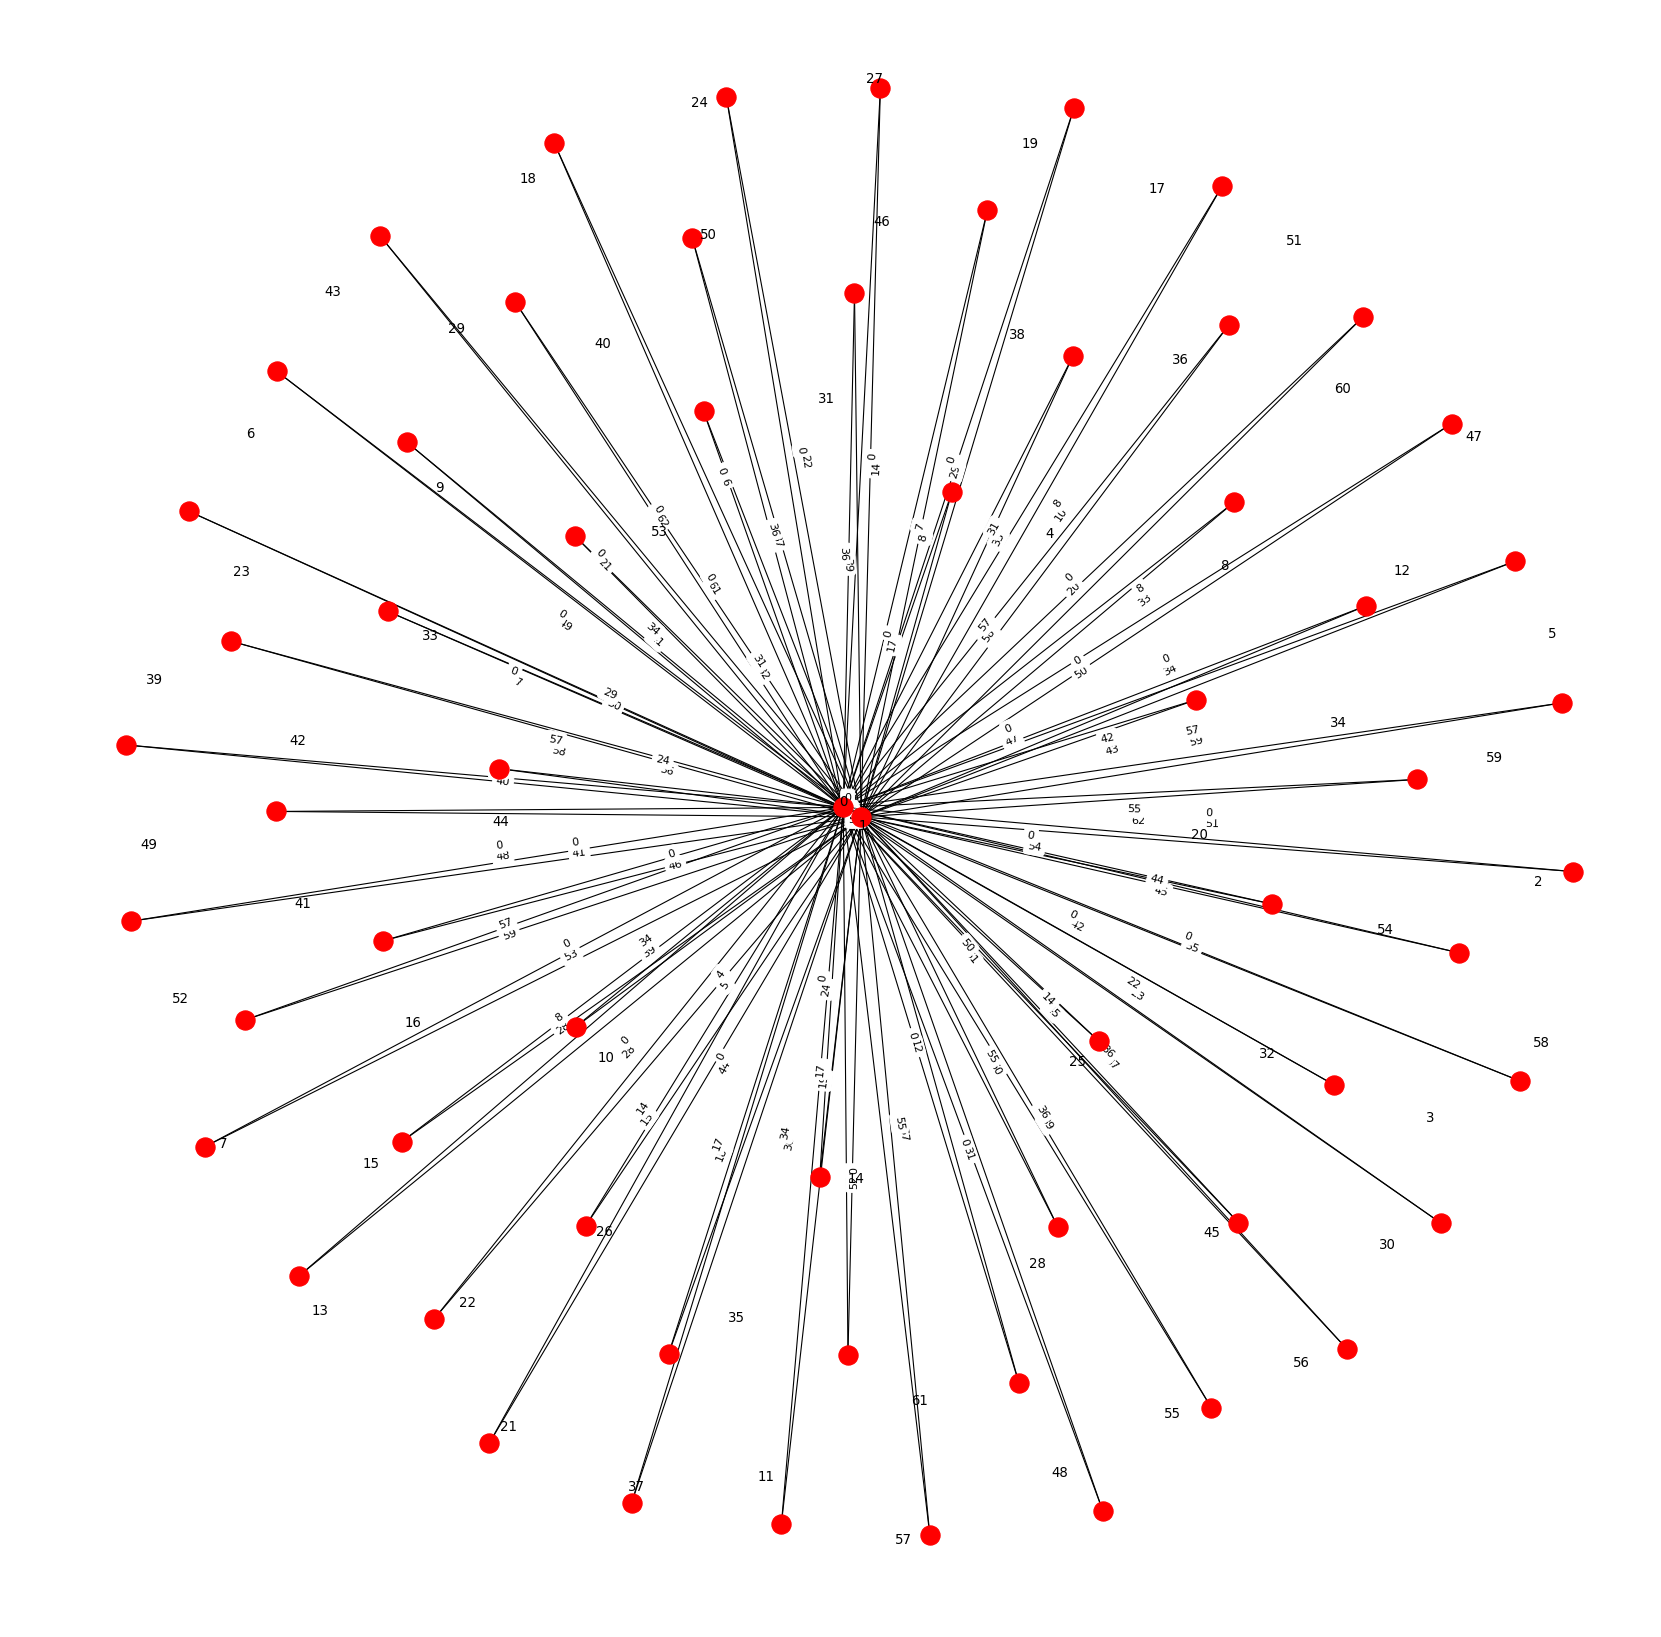

In [43]:
visualize_graph(edges, idx_map2)

In [33]:
# important links
# https://stackoverflow.com/questions/28372127/add-edge-weights-to-plot-output-in-networkx
# https://github.com/networkx/networkx/issues/3078